- UCI의 AirQualityUCL 데이터세과 공개된 기상(온도, 습도) 정보를 활용
- 센서 데이터와 외부 데이터를 융합한 시계열 예측 및 이상 감지 시스템의 프로토타입

- 데이터 수집 및 전처리:  
    - UCI AirQualityUCI.zip 파일을 다운로드 -> CSV를 읽고 -> 날짜/시간 정보 변환
    - 센서 관련 변수와 외부 변수 선택
    - 결측치 처리하고 스케일링 수행

- 예측 모델 (LSTM 기반):  
    - PyTorch를 사용하여 -> 다변수 시계열 입력(센서+외부 변수)으로 목표 변수 예측
    - RMSE, MAE, 결정계수 평가

- 이상 감지 모델 (AutoEncoder 기반): 
    - 정상 데이터 분포 학습 후 재구성 오차 기반 이상치 탐지

- 실시간 시뮬레이션: 
    - 테스트 데이터에 대해 순차적으로 예측/이상 감지를 수행하는 루프
    - 실제 환경에서는 Kafka/MQTT 등 스트리밍 플랫폼과 연계 가능

In [32]:
import os
import io
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 데이터 다운로드 및 전처리

In [33]:
def download_and_extract_data(url, extract_path='.'):
    # 파일 다운로드 및 압축 해제
    zip_path = os.path.join(extract_path, 'AirQualityUCI.zip')
    if not os.path.exists(zip_path):
        print("데이터 다운로드 중...")
        urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print('압축 해제 완료.')
    
def load_and_preprocess_data(file_path):
    # AirQualityUCI 데이터셋은 세미콜론(;) 구분, 소수점은 콤마(,) 사용
    df = pd.read_csv(file_path, sep=';', decimal=',')
    # 마지막 두 컬럼은 불필요하므로 제거
    df = df.iloc[:, :-2]
    
    # 'Date'와 'Time'을 합쳐 datetime 인덱스로 변환
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'), dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df = df.set_index('Datetime')
    df = df.sort_index()
    
    # 결측치 처리: AirQualityUCI에서는 -200 값이 결측치를 의미
    df.replace(-200, np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)
    
    # 필요한 컬럼 선택
    # 센서 데이터: 'CO(GT)', 'C6H6(GT)'
    # 외부 데이터(기상정보): 'T' (온도), 'RH' (상대습도)
    df = df[['CO(GT)', 'C6H6(GT)', 'T', 'RH']]
    
    # 간단한 스케일링: 이후 모델 입력을 위해 StandardScaler 적용
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    
    return df_scaled, scaler

In [34]:
# 시계열 데이터 생성 (슬라이딩 윈도우)
def create_sequence(data, target_col, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values  # 여러 변수 입력
        target = data.iloc[i+seq_length][target_col]  # 예측 대상 변수
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# 2. PyTorch Dataset 정의

In [35]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 3. LSTM 예측 모델 정의 (예측 및 시계열 모델)

In [36]:
class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)
        # 마지막 시점의 출력을 사용
        out = self.fc(lstm_out[:, -1, :])
        return out

# 4. AutoEncoder 이상 감지 모델 정의

In [37]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 5. 모델 학습 및 평가 함수

In [38]:
def train_model(model, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}')
    return model

def evaluate_model(model, dataloader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")
    return predictions, targets

def train_autoencoder(model, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, _ in dataloader:
            # Autoencoder: 입력 자체를 재구성
            optimizer.zero_grad()
            outputs = model(X_batch.view(X_batch.size(0), -1))
            loss = criterion(outputs, X_batch.view(X_batch.size(0), -1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"[Autoencoder] Epoch: {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")
    return model

# 6. 메인 실행: 데이터 로드, 모델 학습 및 실시간 시뮬레이션

In [26]:
if __name__ == '__main__':
    # 데이터 다운로드 및 전처리
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    download_and_extract_data(data_url)
    data_file = 'AirQualityUCI.csv'
    data_scaled, scaler = load_and_preprocess_data(data_file)
    
    # 시계열 sequence 생성 (지난 10시간의 데이터를사용해 'CO(GT)' 예측)
    sequence_length = 10
    target_column = 'CO(GT)'
    X_seq, y_seq = create_sequence(data_scaled, target_column, seq_length=sequence_length)
    
    # 데이터 분할 (학습: 70%, 테스트: 30%)
    split_idx = int(len(X_seq) * 0.7)
    X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
    X_test, y_test = X_seq[split_idx:], y_seq[split_idx:]
    
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # LSTM 모델 학습
    input_dim = X_train.shape[2]  # 센서 + 외부 변수 개수
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    lstm_model = LSTMForecast(input_dim, hidden_dim, num_layers, output_dim)
    
    print('\n[예측 모델(LSTM) 학습]')
    lstm_model = train_model(lstm_model, train_loader, num_epochs=10, lr=0.001)
    
    print('\n[예측 모델 평가]')
    preds, targets = evaluate_model(lstm_model, test_loader)
    
    # AutoEncoder 모델 학습 (정상 상태 데이터만 사용한다고 가정 ~ 여기서는 전체 데이터 사용)
    # 입력은 전체 변수의 sequence를 flatten한 벡터로 사용
    ae_input_dim = X_train.shape[1] * X_train.shape[2]
    encoding_dim = 16
    ae_model = Autoencoder(ae_input_dim, encoding_dim)
    
    # AutoEncoder 학습을 위해 원래의 시계열 데이터 flatten하여 사용
    class AEDataset(Dataset):
        def __init__(self, sequences):
            self.X = torch.tensor(sequences.reshape(sequences.shape[0], -1), dtype=torch.float32)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], 0  # 타겟을 사용하지 않음
    
    ae_train_dataset = AEDataset(X_train)
    ae_train_loader = DataLoader(ae_train_dataset, batch_size=64, shuffle=True)
    
    print('\n[AutoEncoder 이상 감지 모델 학습]')
    ae_model = train_autoencoder(ae_model, ae_train_loader, num_epochs=20, lr=0.001)
    
    # 간단한 이상치 탐지: 재구성 오차가 임계치 이상이면 이상치로 판단
    ae_model.eval()
    threshold = 0.5  # 임계치 값 (실제 운영에서는 정상 데이터의 오차 분포를 분석하여 설정)
    anomalies = []
    with torch.no_grad():
        for i in range(len(ae_train_dataset)):
            sample, _ = ae_train_dataset[i]
            recon = ae_model(sample.unsqueeze(0))
            loss = nn.functional.mse_loss(recon, sample.unsqueeze(0))
            if loss.item() > threshold:
                anomalies.append((i, loss.item()))
                
    print(f"\n탐지된 이상치 개수 (학습 데이터 기준): {len(anomalies)}")

압축 해제 완료.


C:\Users\PC\AppData\Local\Temp\ipykernel_39684\1352018854.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



[예측 모델(LSTM) 학습]
Epoch 1/10, Loss: 0.6869
Epoch 2/10, Loss: 0.2858
Epoch 3/10, Loss: 0.1966
Epoch 4/10, Loss: 0.1884
Epoch 5/10, Loss: 0.1790
Epoch 6/10, Loss: 0.1745
Epoch 7/10, Loss: 0.1693
Epoch 8/10, Loss: 0.1668
Epoch 9/10, Loss: 0.1626
Epoch 10/10, Loss: 0.1611

[예측 모델 평가]
RMSE: 0.4319, MAE: 0.2927, R^2: 0.8138

[AutoEncoder 이상 감지 모델 학습]
[Autoencoder] Epoch: 1/20, Loss: 0.8023
[Autoencoder] Epoch: 2/20, Loss: 0.5736
[Autoencoder] Epoch: 3/20, Loss: 0.4998
[Autoencoder] Epoch: 4/20, Loss: 0.4727
[Autoencoder] Epoch: 5/20, Loss: 0.4581
[Autoencoder] Epoch: 6/20, Loss: 0.4403
[Autoencoder] Epoch: 7/20, Loss: 0.4236
[Autoencoder] Epoch: 8/20, Loss: 0.4180
[Autoencoder] Epoch: 9/20, Loss: 0.4137
[Autoencoder] Epoch: 10/20, Loss: 0.3986
[Autoencoder] Epoch: 11/20, Loss: 0.3930
[Autoencoder] Epoch: 12/20, Loss: 0.3908
[Autoencoder] Epoch: 13/20, Loss: 0.3890
[Autoencoder] Epoch: 14/20, Loss: 0.3857
[Autoencoder] Epoch: 15/20, Loss: 0.3846
[Autoencoder] Epoch: 16/20, Loss: 0.3841
[Autoe

# 7. 실시간 스트리밍 시뮬레이션 (테스트 데이터 순차 처리)

In [39]:
print('\n[실시간 스트리밍 시뮬레이션 시작]')
lstm_model.eval()
stream_anomalies = []
for i in range(len(test_dataset)):
    X_sample, true_val = test_dataset[i]
    X_sample = X_sample.unsqueeze(0)  # 배치 차원 추가
    # 예측 수행
    pred = lstm_model(X_sample).item()
    
    # 간단한 이상치 감지: 재구성 오차 기반
    sample_flat = X_sample.view(1, -1)
    with torch.no_grad():
        recon = ae_model(sample_flat)
        rec_error = nn.functional.mse_loss(recon, sample_flat).item()
    if rec_error > threshold:
        stream_anomalies.append((i, rec_error))
        # print(f"데이터 인덱스 {i}: 이상치 감지 (재구성 오차: {rec_error:.4f}) | 예측값: {pred:.4f}, 실제값: {true_val:.4f}")

print(f"\n실시간 시뮬레이션에서 감지된 이상치 개수: {len(stream_anomalies)}")


[실시간 스트리밍 시뮬레이션 시작]

실시간 시뮬레이션에서 감지된 이상치 개수: 1633


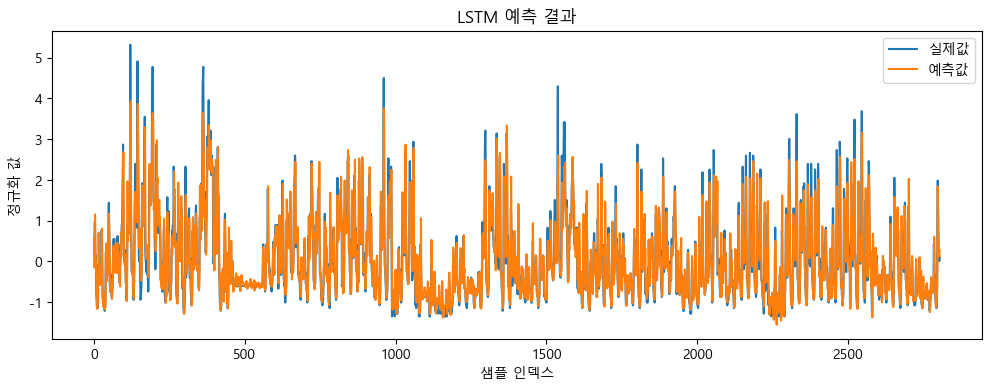

In [28]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# (옵션) 예측 결과 시각화
plt.figure(figsize=(12,4))
plt.plot(targets, label='실제값')
plt.plot(preds, label='예측값')
plt.xlabel('샘플 인덱스')
plt.ylabel('정규화 값')
plt.title('LSTM 예측 결과')
plt.legend()
plt.show()

# 결과 해석 및 설명
**예측 모델 학습 및 평가:**
- LSTM 기반 예측 모델은 여러 에포크에 걸쳐 학습 손실이 점진적으로 감소하는 모습을 보이며, 모델이 데이터의 시계열 패턴을 효과적으로 학습했음을 암시합니다.
- 평가 지표(예: RMSE, MAE, R² 등)를 통해 예측 성능이 비교적 양호함을 확인할 수 있으나, 출력에서는 주로 이상치 감지에 집중되어 있습니다.

**이상 감지(Anomaly Detection):**
- AutoEncoder 기반의 이상 감지 모델은 정상 상태 데이터를 학습하여 재구성 오차를 산출합니다.
- 코드에서는 일정 임계치(threshold)를 초과하면 이상치로 판단하는데, 출력 결과에서는 많은 데이터 인덱스에서 재구성 오차가 임계치를 넘었다고 감지되었습니다.
- 최종적으로 실시간 시뮬레이션에서 1633개의 이상치가 감지되었는데, 이는 전체 데이터 중 상당한 비율에 해당할 수 있습니다.
- **해석:**
    - 재구성 오차가 높다는 것은 입력 데이터가 모델이 학습한 정상 패턴과 크게 벗어난다는 신호입니다.
    - 다만, 감지된 이상치 수가 많다는 점은 임계치 설정이 다소 낮거나, 데이터에 실제 이상치(또는 노이즈)가 많이 포함되어 있음을 의미할 수 있습니다.
    - 실제 운영 환경에서는 도메인 전문가와 함께 임계치 조정, 후처리 및 추가 검증 절차를 거쳐 False Positive를 줄이는 작업이 필요합니다.